In [ ]:
import plotly.express as px
import pandas as pd
import numpy as numpy

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
hongos = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/secondary_data.csv", sep=";")


# Nans:


**Las siguientes variables cuentan con valores de Nan y seran reemplazadas. Como regla general, se utilizara other cuando se puede asegurar que tiene valor y unknown cuando no se sabe si siquiera ese dato podria tener valor (caso de color/forma de cosas que no se sabe siquiera si lo tiene, etc).**


- Cap surface: como es un dato que obligatoriamente tiene cualquier hongo, voy   a tomar los nan y los "d" (debido a que es un valor no especificado en el paper) como otros = "o"

- gill-attachment: El nan se especifica que es desconocido por el paper (unknown=?) asi que sera reemplazado por "u".

- Gill-Spacing:
  1. Para los hongos que tienen gill-attachment none (f): se reemplazara por f. Esto se ve respaldado por el hecho que todos los hongos que no tienen gill.attachment y tienen gill-spacing conocido tienen valor f, no puede tener spacing si no tiene gills.

  2. Para los hongos que tienen gill-attachment distinto a u/f: seran reemplazados por others = "o" puesto que se sabe que si tienen gills, solo que no se sabe el spacing.

  3. Para los que no se sabe si tienen gill-attachment (u), se utilizara unknown = "u".

- Stem-Root: existe un valor desconocido, que no aparece en la documentacion (f) y Nans, ambos seran reemplazados por other, puesto que si o si tiene que tener stem.

- Stem-Surface: debido a que todo registro tiene stem-height/width/color es un poco raro que exista la posibilidad de tener none (f) como valor posible, puesto que todo tiene alguna textura de superficie. Para que tengan sentido los nans y los f se utilizara other = "o".

- veil-type: puesto que no puedo asumir que porque ninguno es parcial que alguno de ellos lo es, se reemplazaran los nans de la siguiente forma:
  1. Aquellos que tengan veil-color distinto a Nan o f: other = "o".
  
  2. Aquellos que no se sepa el veil-color: unknown = "n". Se utiliza porque ya existe la u como valor.

- Veil-color:
  1. Si veil-type es unknown: unknown (n, puesto que ya existe u).
  2. Si veil.type es distinto a uknown: other.

- Ring-type: se especifica la existencia de unknown = ?, por lo que sera reemplazado por "u".

- spore-print-color: Nans seran reemplazados por other = "o".


In [ ]:
#Cap surface:
hongos.loc[hongos['cap-surface'] == 'd', 'cap-surface'] = "o"
hongos['cap-surface'] = hongos['cap-surface'].fillna("o")

#gill-attachment:
hongos['gill-attachment'] = hongos['gill-attachment'].fillna("u")

#gill-spacing
hongos.loc[(hongos['gill-attachment'] == 'f') & (hongos['gill-spacing'].isnull()), 'gill-spacing'] = "f"
hongos.loc[(hongos['gill-attachment'] == 'u') & (hongos['gill-spacing'].isnull()), 'gill-spacing'] = "u"
hongos['gill-spacing'] = hongos['gill-spacing'].fillna("o")

#Stem-Root:
hongos.loc[hongos['stem-root'] == 'f', 'stem-root'] = "o"
hongos['stem-root'] = hongos['stem-root'].fillna("o")

#stem-surface
hongos.loc[hongos['stem-surface'] == 'f', 'stem-surface'] = "o"
hongos['stem-surface'] = hongos['stem-surface'].fillna("o")

#Veil-Type (noto que veil-color no tiene f, solo nan)
hongos.loc[(hongos['veil-color'].notnull()) & (hongos['veil-type'].isnull()), 'veil-type'] = "o"
hongos['veil-type'] = hongos['veil-type'].fillna("n") #ya existe u

#Veil-color
hongos.loc[(hongos['veil-type'] == 'n') & (hongos['veil-color'].isnull()), 'veil-color'] = "n" #ya existe u
hongos['veil-color'] = hongos['veil-color'].fillna("n")

#ring-type:
hongos['ring-type'] = hongos['ring-type'].fillna("u")

#Spore-print-color:
hongos['spore-print-color'] = hongos['spore-print-color'].fillna("o")


# Separar datos

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
x = hongos.drop('class', axis=1)
y = hongos['class']

In [ ]:
x = x.astype({"stem-height":"float","stem-width":"float","cap-diameter":"float"})

In [ ]:
from sklearn.preprocessing import StandardScaler

In [ ]:
scaler = StandardScaler()

In [ ]:
x[['stem-height','stem-width','cap-diameter']] = pd.DataFrame(scaler.fit_transform(x[['stem-height','stem-width','cap-diameter']]), columns=[['stem-height','stem-width','cap-diameter']])

In [ ]:
x_train, x_separar, y_train, y_separar = train_test_split(x, y, test_size=0.2, random_state=5)

In [ ]:
x_test, x_validation, y_test, y_validation = train_test_split(x_separar, y_separar, test_size=0.5, random_state=5)

In [ ]:
#Me los guardo para que el csv quede sin las columnas encodeadas
x_test_sin_encodear = x_test
y_test_sin_encodear = y_test

# Encoding

Realizo el encoding de test, validation y train por separado asi no filtro datos. Se eligieron los encoders Binary Encoder y OHE.


In [ ]:
from sklearn.preprocessing import OneHotEncoder
!pip install category_encoders
import category_encoders as ce

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 8.7 MB/s eta 0:00:00


In [ ]:
columnas = ['cap-shape','cap-surface','cap-color','gill-attachment','gill-spacing','gill-color','stem-root','stem-surface','stem-color',
            'veil-type','veil-color','ring-type','spore-print-color','habitat','season']
for columna in columnas:
  encoder = ce.BinaryEncoder(cols=[columna])
  x_train = encoder.fit_transform(x_train)

  x_test = encoder.transform(x_test)
  x_validation = encoder.transform(x_validation)

In [ ]:
#bleed
ohe_bleed = OneHotEncoder(drop='first')
x_train['does-bruise-or-bleed'] = ohe_bleed.fit_transform(x_train[['does-bruise-or-bleed']]).todense().astype(int)

x_test['does-bruise-or-bleed'] = ohe_bleed.transform(x_test[['does-bruise-or-bleed']]).todense().astype(int)
x_validation['does-bruise-or-bleed']= ohe_bleed.transform(x_validation[['does-bruise-or-bleed']]).todense().astype(int)


In [ ]:
# has-ring
ohe_ring = OneHotEncoder(drop='first')
x_train['has-ring'] = ohe_ring.fit_transform(x_train[['has-ring']]).todense().astype(int)

x_test['has-ring'] = ohe_ring.transform(x_test[['has-ring']]).todense().astype(int)
x_validation['has-ring']= ohe_ring.transform(x_validation[['has-ring']]).todense().astype(int)


Encodeo target

In [ ]:
#class
class_OHE = ce.OneHotEncoder(cols=['class'])

y_train = class_OHE.fit_transform(y_train).iloc[:, 0]

y_test =  class_OHE.transform(y_test).iloc[:, 0]
y_validation =  class_OHE.transform(y_validation).iloc[:, 0]


# Regresion Logistica


In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import roc_auc_score

In [ ]:
log_reg = LogisticRegression(random_state = 0, max_iter= 10000)

In [ ]:
params = [
    {'penalty': ['l1', 'l2', 'elasticnet', 'None']},
    {'C': [ 1.376,1.378,1.379,1.38,1.381,1.382,1.383]},
    {'solver':['lbfgs', 'newton-cg','newton-cholesky']}
]

In [ ]:
grid_search = GridSearchCV(log_reg, param_grid =params, scoring='roc_auc')

In [ ]:
grid_search.fit(x_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
15 fits failed out of a total of 70.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 54, in _check_solver
    raise ValueError(
ValueError: Solver

GridSearchCV(estimator=LogisticRegression(max_iter=10000, random_state=0),
             param_grid=[{'penalty': ['l1', 'l2', 'elasticnet', 'None']},
                         {'C': [1.376, 1.378, 1.379, 1.38, 1.381, 1.382,
                                1.383]},
                         {'solver': ['lbfgs', 'newton-cg', 'newton-cholesky']}],
             scoring='roc_auc')

In [ ]:
grid_search.best_params_

{'C': 1.38}

Resultado hiperparametros :{'C': 1.38}

In [ ]:
model = grid_search.best_estimator_

In [ ]:
model.fit(x_train, y_train)

LogisticRegression(C=1.38, max_iter=10000, random_state=0)

In [ ]:
proba_pred_val = model.predict_proba(x_validation)[:, 1]

In [ ]:
roc_auc_score(y_validation, proba_pred_val)

0.8797042731446126

Mejor resultado Auc-Roc obtenido = 0.8797042731446126
Detalles que lo implementaron: mejora progresiva de C, diferenciar "otros" y "unknown" en nans, aumentar max iter y estandarizar columnas con valores numericos.

Debido a que los datos no tienen cronologia ni dice haber multiples entradas de un mismo hongo segun la documentacion, se opto por dividir el modelo en 80% train (para tener mayor cantidad de datos para entrenar el modelo) y luego 10% validacion y 10% test.

# Importancia features

                 Feature  Importancia
14            veil-color    21.641145
17     spore-print-color    17.677440
10             stem-root    11.414921
13             veil-type     8.486677
11          stem-surface     6.773653
12            stem-color     4.317421
18               habitat     2.984522
16             ring-type     2.833584
5        gill-attachment     2.731750
2            cap-surface     1.924161
1              cap-shape     1.533570
6           gill-spacing     1.515788
3              cap-color     1.326236
7             gill-color     1.156172
19                season     1.029087
0           cap-diameter     0.625265
15              has-ring     0.568444
8            stem-height     0.427973
9             stem-width     0.382307
4   does-bruise-or-bleed     0.167705


[Text(0.5, 1.0, 'Features más Importantes')]

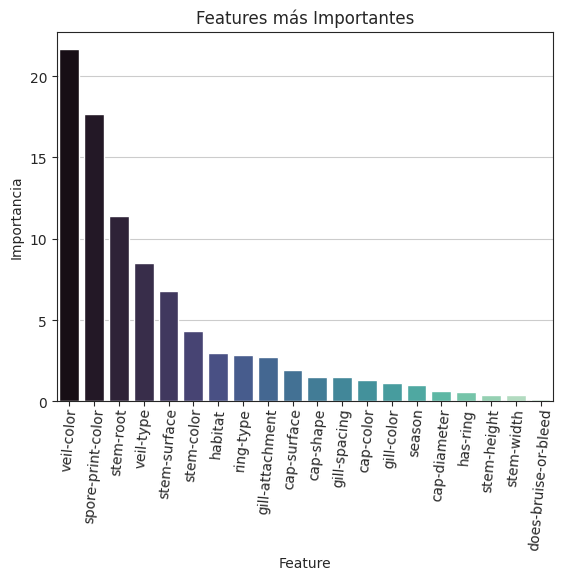

In [ ]:
import seaborn as sns
import numpy as np
from matplotlib import rcParams

k_mas_importantes = 20 #cantidad de features q se quieren mostrar, max = 20
coefs = grid_search.best_estimator_.coef_[0]

importancia = {}
for i in range (len(coefs)):
  key_act = x_train.columns[i]
  if (key_act[-2] == "_"):
    key_act = key_act[0:-2]
  if key_act not in importancia.keys():
    importancia[key_act] = abs(coefs[i])
  else:
    importancia[key_act] += abs(coefs[i])

grafico = pd.DataFrame({'Feature':importancia.keys(), 'Importancia':importancia.values()})
grafico = grafico.reindex(grafico.Importancia.abs().sort_values(ascending=False).index)
print(grafico)
#Bar plot
sns.set_style("ticks",{'axes.grid' : True})
bar = sns.barplot(data = grafico.iloc[0:k_mas_importantes], x = 'Feature', y='Importancia', palette = "mako")
bar.tick_params(axis='x', rotation=85, pad = 0.5)
bar.set(title="Features más Importantes")


# Test:


In [ ]:
y_pred_test = model.predict(x_test)

In [ ]:
proba_pred_test = model.predict_proba(x_test)[:, 1]

In [ ]:
roc_auc_score(y_test, proba_pred_test)

0.8819073568535698

Resultado Auc: 0.8819073568535698

# Guardar prediccion test

In [ ]:
csv_predicciones = x_test_sin_encodear

y_pred = pd.Series(y_pred_test).map({0: 'p', 1: 'e'})

csv_predicciones = csv_predicciones.assign(predicted_class_reg_log = y_test.values)
csv_predicciones = csv_predicciones.assign(expected_class = y_pred.values)

csv_predicciones.to_csv('predicciones_test_reg_log.csv')